# Multi-class Classification Model Using Neural Newtwork with PyTorch

Dataset: Creates a 4-class dataset using sklearn's make_blobs

The notebook is hands-on practice of [this tutorial](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb).

#### 1. Import the dependencies

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
# Setting up the GPU (Although we do not use it here)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### 2. Create dataset

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


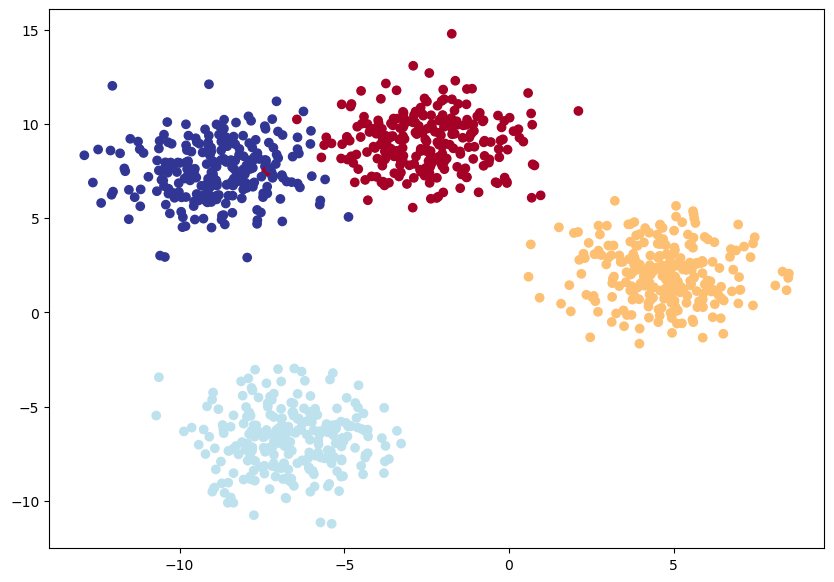

In [3]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

#### 3. Split data into training and test 

In [4]:
# Train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                y_blob,test_size=0.2, random_state=RANDOM_SEED)

#### 4. Build the PyTorch Model

In [5]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        
        super().__init__()
        self.model0 = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.Linear(in_features = hidden_units, out_features = output_features)
        )
            
    def forward(self, x):
            return self.model0(x)
            
#  Create an instance of BlobModel and send it to the target device
my_model = BlobModel(input_features = NUM_FEATURES,
                    output_features = NUM_CLASSES, 
                    hidden_units = 8)
my_model

BlobModel(
  (model0): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
# single forward pass with our model to see if it works
my_model(X_blob_train.to(device))[:5]

tensor([[ 0.0075, -0.7424,  0.5693, -0.0919],
        [ 1.2797,  0.3700,  1.5330,  0.2924],
        [ 1.4144,  1.1487, -1.3324, -0.1034],
        [ 1.2395,  0.8081, -0.6225, -0.0323],
        [ 1.2939,  0.4641,  1.1767,  0.2427]], grad_fn=<SliceBackward0>)

In [7]:
# make prediction logits
y_logits = my_model(X_blob_train.to(device))
print(y_logits.shape)

# Apply softmax to get prediction prob
y_prob = torch.softmax(y_logits, dim=1)
print(y_prob.shape)
y_prob[:5]

torch.Size([800, 4])
torch.Size([800, 4])


tensor([[0.2420, 0.1143, 0.4245, 0.2191],
        [0.3264, 0.1314, 0.4205, 0.1216],
        [0.4878, 0.3740, 0.0313, 0.1069],
        [0.4795, 0.3115, 0.0745, 0.1344],
        [0.3738, 0.1630, 0.3325, 0.1307]], grad_fn=<SliceBackward0>)

In [8]:
# Sum of prob of 0th tensor
print(torch.sum(y_prob[0]))

# Use argmax to get the index of max value
print(y_prob[2])
print(torch.argmax(y_prob[2]))

tensor(1., grad_fn=<SumBackward0>)
tensor([0.4878, 0.3740, 0.0313, 0.1069], grad_fn=<SelectBackward0>)
tensor(0)


#### 5. Model Training

In [9]:
# Import Accuracy metric
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [10]:
# Set accuracy function to the device
accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

#### 5.1. Loss function and optimizer 

In [11]:
# Define loss function & optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.1)

#### 5.2. Train and test the model

In [12]:
torch.manual_seed(RANDOM_SEED)

# Define epoch
epochs = 100

# Put data to target  device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # Training
    my_model.train()
    
    # 1. Forward pass
    y_logits = my_model(X_blob_train).squeeze()
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy(y_pred, y_blob_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Backward prop
    loss.backward()
    
    # 5. step
    optimizer.step() 
    
    
    
    # Testing the model
    my_model.eval()
    with torch.inference_mode():
        
        test_logits = my_model(X_blob_test) # model outputs raw logits 
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test) 
        test_acc = accuracy(test_pred, y_blob_test)
        
        # To see what's happening every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 2.12424, Acc: 0.06% | Test Loss: 0.81615, Test Acc: 0.62%
Epoch: 10 | Loss: 0.18359, Acc: 0.99% | Test Loss: 0.16219, Test Acc: 1.00%
Epoch: 20 | Loss: 0.09402, Acc: 0.99% | Test Loss: 0.08385, Test Acc: 1.00%
Epoch: 30 | Loss: 0.06605, Acc: 0.99% | Test Loss: 0.05748, Test Acc: 1.00%
Epoch: 40 | Loss: 0.05312, Acc: 0.99% | Test Loss: 0.04486, Test Acc: 1.00%
Epoch: 50 | Loss: 0.04583, Acc: 0.99% | Test Loss: 0.03757, Test Acc: 1.00%
Epoch: 60 | Loss: 0.04121, Acc: 0.99% | Test Loss: 0.03286, Test Acc: 1.00%
Epoch: 70 | Loss: 0.03804, Acc: 0.99% | Test Loss: 0.02958, Test Acc: 1.00%
Epoch: 80 | Loss: 0.03576, Acc: 0.99% | Test Loss: 0.02716, Test Acc: 1.00%
Epoch: 90 | Loss: 0.03404, Acc: 0.99% | Test Loss: 0.02530, Test Acc: 1.00%


#### 6. Make Predictions

In [13]:
# Make prediction 
my_model.eval()
with torch.inference_mode():
    y_logits = my_model(X_blob_test)
        
# Convert logits ---> probs ----> labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

# print the results
print(f"Predictions: {y_pred[:10]}\nOriginal Labels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy(y_blob_test, y_pred)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Original Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 0.9950000047683716%


#### 7. Plot the results

In [14]:
# Import helper function to plot the results
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

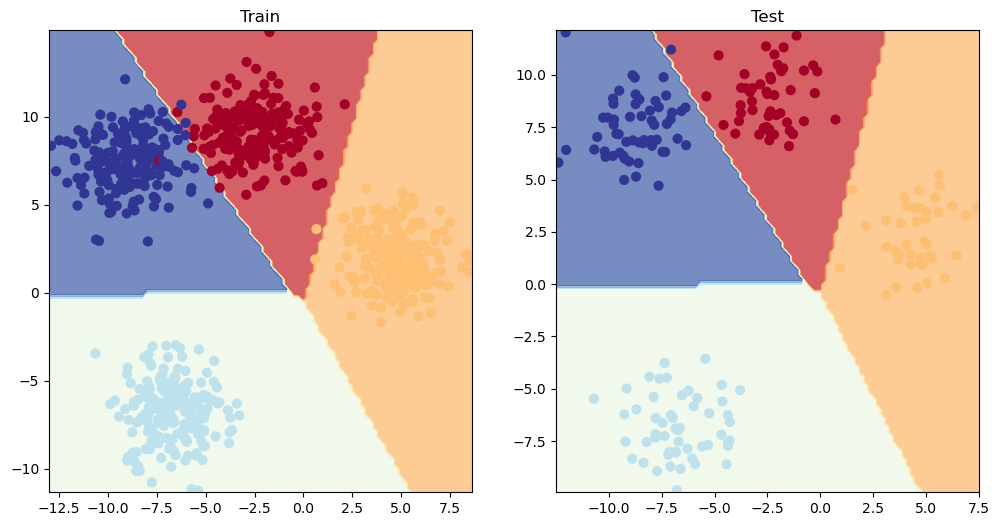

In [15]:
# The plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(my_model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(my_model, X_blob_test, y_blob_test)